In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# import dataset
housing_data = pd.read_csv('/content/drive/MyDrive/ML datasets/housing.csv')

In [3]:
# feature engineering

housing_data['rooms per household'] = housing_data['total_rooms'] / housing_data['households']
housing_data['bedrooms per total_rooms'] = housing_data['total_bedrooms'] / housing_data['total_rooms']
housing_data['population per household'] = housing_data['population'] / housing_data['households']

In [4]:
housing_data.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [5]:
housing_data = housing_data.dropna()

## Exploratory Data Analysis

In [6]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms per household,bedrooms per total_rooms,population per household
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,5.431344,0.213039,3.071533
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,2.482946,0.057983,10.438269
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000,4.441441,0.175427,2.429032
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,5.230769,0.203162,2.817582
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000,6.052381,0.239821,3.281513
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


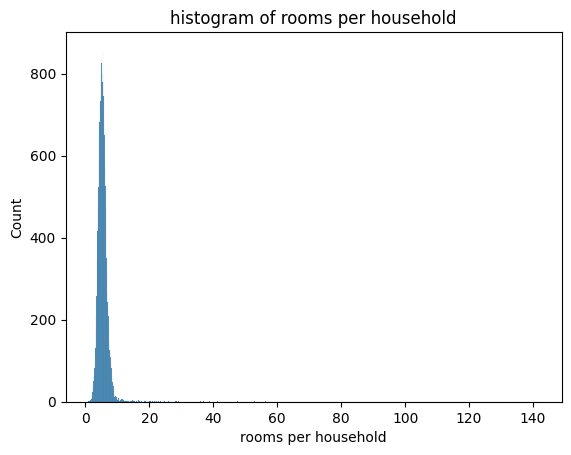

In [7]:
# histogram of rooms per household
sns.histplot(data = housing_data, x = 'rooms per household')
plt.title('histogram of rooms per household')
plt.show()

The distribution of rooms per household is strongly right-skewed, with most observations concentrated at lower values and a small number of extreme values forming a long tail.

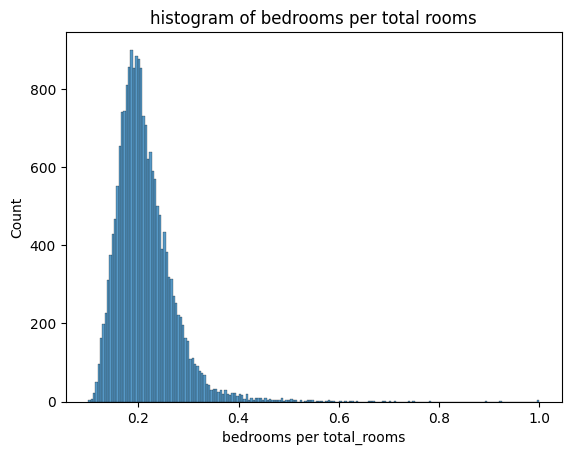

In [8]:
# histogram of bedrooms per total rooms
sns.histplot(data = housing_data, x = 'bedrooms per total_rooms')
plt.title('histogram of bedrooms per total rooms')
plt.show()

The distribution is slightly right-skewed, with a small number of areas having unusually high bedroom proportions.

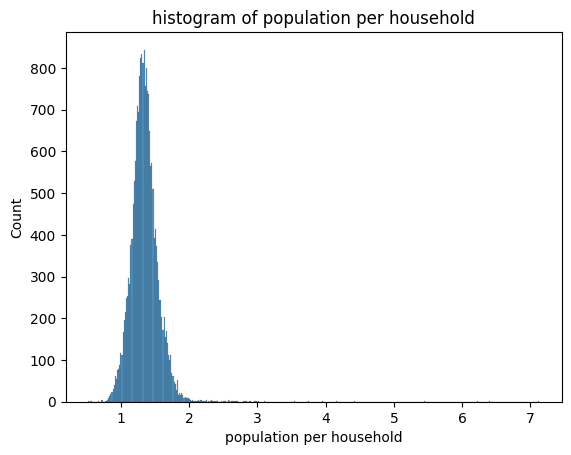

In [9]:
# histogram of population per household
sns.histplot(data = housing_data, x = np.log1p(housing_data['population per household']))
plt.title('histogram of population per household')
plt.show()

due the the very high skewness of the original feature, Log transformation is used to reduce skewness and outlier influence, resulting in a clearer and more interpretable distribution.
So The distribution of log transformed population per household is right-skewed.

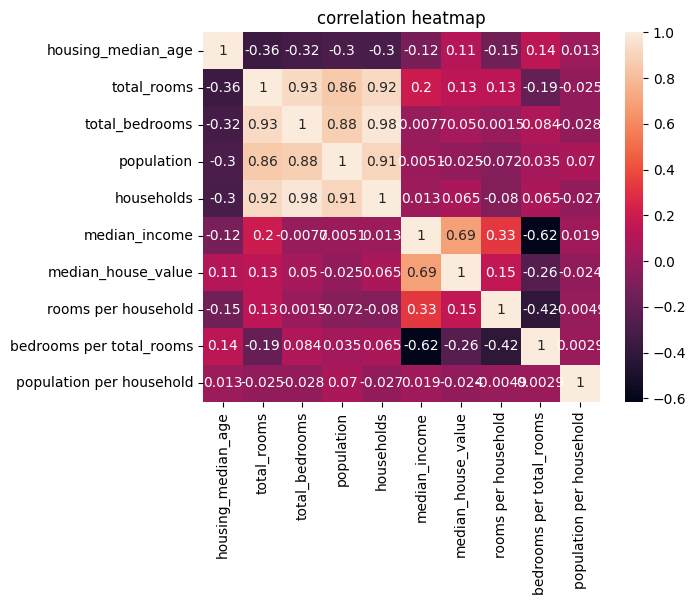

In [10]:
# heatmap
cor = housing_data.drop(columns = ['latitude', 'longitude', 'ocean_proximity']).corr()
sns.heatmap(cor, annot = True)
plt.title('correlation heatmap')
plt.show()

rooms per households shows a moderate positive correlation with median income (0.33) and median house value (0.15) and Weak correlations with population related variables indicate that this feature captures housing quality rather than crowding.

bedrooms per total rooms exhibits a strong negative correlation with median income (-0.62) and a moderate negative correlation with median house value (-0.26). This indicates that lower bedroom density is associated with high income areas and higher house values.

population per household shows very weak correlations with nearly all variables, including median house value (-0.02) and median income (0.02).

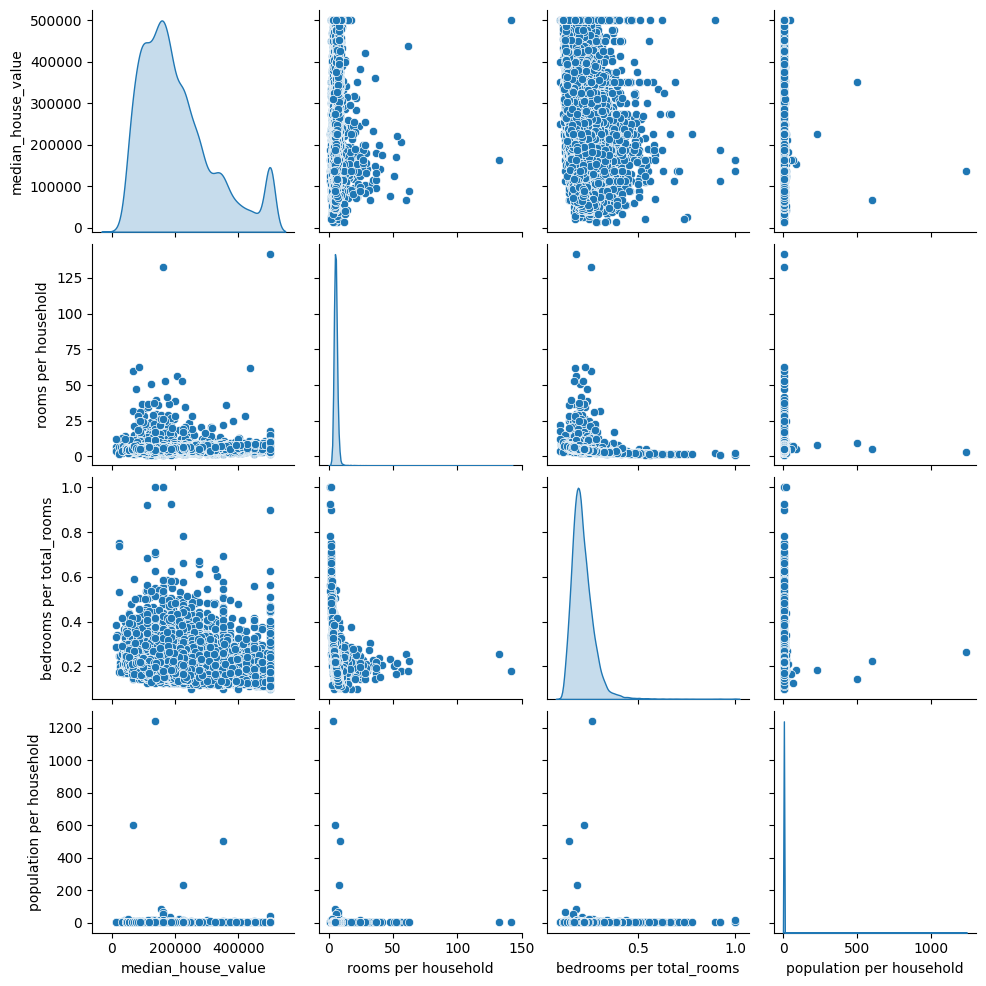

In [11]:
sns.pairplot(housing_data.drop(columns = ['latitude', 'longitude', 'ocean_proximity', 'total_rooms', 'population', 'total_bedrooms', 'households',
                                          'housing_median_age', 'median_income']), diag_kind = 'kde')
plt.show()

In [12]:
# defining target and feature variables

x = housing_data.drop(columns = ['latitude', 'longitude', 'median_house_value'], axis = 1)
y = housing_data['median_house_value']

# identifying numerical and categorical features

num_features = list(housing_data.drop(columns = ['latitude', 'longitude', 'ocean_proximity', 'median_house_value']))
cat_features = ['ocean_proximity']

# skewed and non skewed features

skewed_features = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms per household', 'bedrooms per total_rooms',
                   'population per household']
nonskewed_features = ['housing_median_age']

In [13]:
# training and testing set splitting

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 524)

### Linear Regression

In [14]:
# preprocessor

preprocessor = ColumnTransformer(
    transformers = [
        # log transfomration and scaling for numerical skewed features
        ('log_scaled', Pipeline([
            ('log', FunctionTransformer(np.log1p, validate = False)),
            ('scaler', StandardScaler())]), skewed_features),

        # scaling for non skewed numerical features
        ('scaler', StandardScaler(), nonskewed_features),

        # one hot encoder for ategorical features
        ('encoder', OneHotEncoder(drop = 'first'), cat_features)
    ])


In [15]:
# pipeline for model

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [16]:
# model fitting and predicting

lr_pipeline.fit(x_train, y_train)
lr_y_pred = lr_pipeline.predict(x_test)

In [17]:
# model evaluation

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("R²:", lr_r2)

MSE: 4575175746.653709
RMSE: 67640.04543651424
R²: 0.6634479034874577


The model explains about 66% of the variance in median house values.
Compared to the linear regression without the three created features, the R² shows a modest improvement, indicating better handling of housing prices.

The RMSE of 67,640 suggests that, on average, predictions deviate from actual house values by around USD 67k, shows a clear reduction in prediction error after including new features.

### Random Forest

In [18]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(drop = 'first'), cat_features)],
    remainder = 'passthrough'
)

In [19]:
# random forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state = 524))
])

In [20]:
# hyperparameter tuning
param_list = {
    'model__n_estimators': [100, 200, 300, 500, 800, 1200],
    'model__max_depth': [10, 20, 30, 40, 50, None],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4, 6],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator = rf_pipeline,
    param_distributions = param_list,
    n_iter = 20,
    scoring = 'neg_mean_squared_error',
    cv = 3,
    verbose = 2,
    random_state = 524,
    n_jobs = -1
)

In [21]:
# fitting the model
random_search.fit(x_train, y_train)

# predicting with best parameters
best_rf = random_search.best_estimator_
print('Best Parameters:', best_rf)

rf_y_pred = random_search.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['ocean_proximity'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features='log2',
                                       min_samples_split=5, n_estimators=800,
                                       random_state=524))])


In [22]:
# model evaluation

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("R²:", rf_r2)

MSE: 3392470935.342306
RMSE: 58244.9219704371
R²: 0.7504482299980736


Feature engineering leads to a noticeable reduction in RMSE, indicating more accurate house value predictions.

The increase in R² by nearly 2 percentage points suggests that engineered features add meaningful information beyond the original variables.

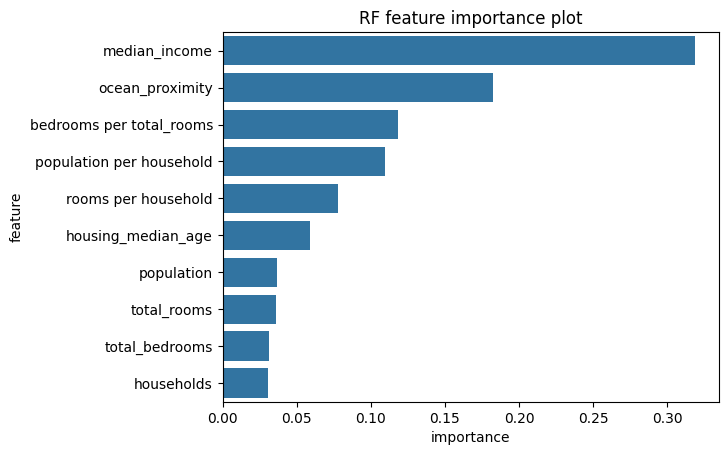

In [23]:
# feature importance plot

rf_model = best_rf.named_steps['model']                 # extracting the best random forest model from pipeline
preprocessor = best_rf.named_steps['preprocessor']      # extracting the preprocessor from pipeline

importances = rf_model.feature_importances_             # extracting feature importances
feature_names = preprocessor.get_feature_names_out()    # extracting the feature names

# creating the dataframe
feature_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('onehot__', '', regex = False)
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('remainder__', '', regex = False)
feature_imp_df['base_feature'] = feature_imp_df['feature']

# Replace all one-hot columns for ocean_proximity with the original feature name
feature_imp_df.loc[feature_imp_df['feature'].str.contains('ocean_proximity'), 'base_feature'] = 'ocean_proximity'

# aggregated dataframe
agg_imp_df = feature_imp_df.groupby('base_feature', as_index = False)['importance'].sum().sort_values(by = 'importance', ascending = False)

# plot
sns.barplot(x = 'importance', y = 'base_feature', data = agg_imp_df)
plt.title('RF feature importance plot')
plt.xlabel('importance')
plt.ylabel('feature')
plt.show()

Income and location remain the dominant drivers of housing prices, while engineered ratio features add meaningful explanatory power than the original features like total rooms and population by capturing housing efficiency and crowding.

### XGBoost

In [24]:
# preprocessing

preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(drop = 'first'), cat_features)],
    remainder = 'passthrough'
)

In [25]:
# pipeline

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state = 524))
])

In [26]:
# hyperparameter tuning

param_list = {
    'model__n_estimators': [300, 500, 800, 1200],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [3, 4, 5, 6, 8],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.3]
}

random_search = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions = param_list,
    n_iter = 20,
    scoring='neg_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1,
    random_state = 42
)

In [27]:
# fitting the model
random_search.fit(x_train, y_train)

# predicting with best parameters
best_xgb = random_search.best_estimator_
print('Best Parameters:', best_xgb)

xgb_y_pred = random_search.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['ocean_proximity'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eva...
                              feature_types=None, feature_weights=None,
                              gamma=0.3, grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
               

In [28]:
# model evaluation
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("R²:", xgb_r2)

MSE: 3321715488.5608664
RMSE: 57634.32561035885
R²: 0.7556530342007082


The model achieves an R² of 0.755, indicating that approximately 76% of the variance in median house values is explained by the predictors.

The RMSE of 57,634 represents the lowest prediction error so far, showing improved accuracy compared to previous models.

Here also it's visible that the using of the new features have improved the model.

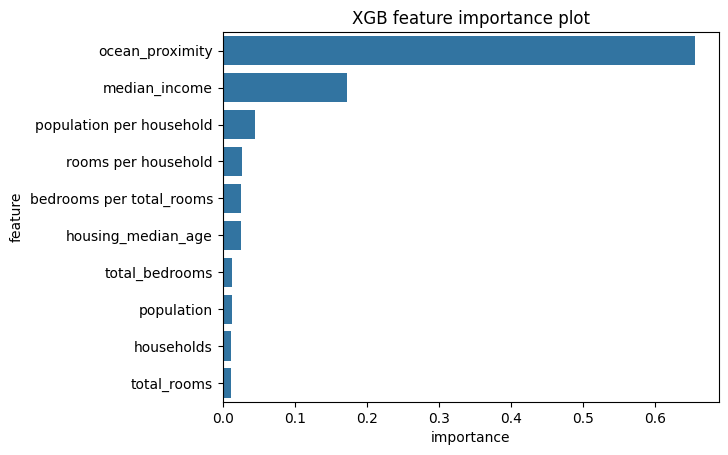

In [30]:
# feature importance plot

xgb_model = best_xgb.named_steps['model']                 # extracting the best random forest model from pipeline
preprocessor = best_xgb.named_steps['preprocessor']      # extracting the preprocessor from pipeline

importances = xgb_model.feature_importances_             # extracting feature importances
feature_names = preprocessor.get_feature_names_out()    # extracting the feature names

# creating the dataframe
feature_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('onehot__', '', regex = False)
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('remainder__', '', regex = False)
feature_imp_df['base_feature'] = feature_imp_df['feature']

# Replace all one-hot columns for ocean_proximity with the original feature name
feature_imp_df.loc[feature_imp_df['feature'].str.contains('ocean_proximity'), 'base_feature'] = 'ocean_proximity'

# aggregated dataframe
agg_imp_df = feature_imp_df.groupby('base_feature', as_index = False)['importance'].sum().sort_values(by = 'importance', ascending = False)

# plot
sns.barplot(x = 'importance', y = 'base_feature', data = agg_imp_df)
plt.title('XGB feature importance plot')
plt.xlabel('importance')
plt.ylabel('feature')
plt.show()

Here also the Income and location remain the dominant drivers of housing prices and engineered ratio features are more important than the original structural features.

### LightGBM

In [32]:
# preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(drop = 'first'), cat_features)],
    remainder = 'passthrough'
)

In [33]:
# pipeline
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state = 524))
])

In [34]:
# hyperparameter tuning

param_list = {
    'model__n_estimators': [500, 800, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [5, 7, 10, -1],
    'model__num_leaves': [31, 50, 100],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator = lgbm_pipeline,
    param_distributions=param_list,
    n_iter = 20,
    cv = 3,
    scoring = 'neg_mean_squared_error',
    verbose = 1,
    n_jobs = -1,
    random_state = 524
)

In [35]:
# fitting the model
random_search.fit(x_train, y_train)

# predicting with best parameters
best_lgbm = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

lgbm_y_pred = best_lgbm.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 12
[LightGBM] [Info] Start training from score 206713.682491
Best Parameters: {'model__subsample': 0.6, 'model__num_leaves': 50, 'model__n_estimators': 800, 'model__max_depth': -1, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [36]:
# model evaluation

lgbm_mse = mean_squared_error(y_test, lgbm_y_pred)
lgbm_rmse = np.sqrt(lgbm_mse)
lgbm_r2 = r2_score(y_test, lgbm_y_pred)

print("MSE:", lgbm_mse)
print("RMSE:", lgbm_rmse)
print("R²:", lgbm_r2)

MSE: 3312633545.4554706
RMSE: 57555.48232319377
R²: 0.7563211062402937


The LightGBM model explains nearly 75.6% of the variability in housing prices, indicating that the modeling with engineered features have increased the model performence.

In [37]:
model_results2 = {
    'models':["Linear Regression", "Random Forest", "XGBoost", "LightGBM"],
    'rmse':[lr_rmse, rf_rmse, xgb_rmse, lgbm_rmse],
    'r2':[lr_r2, rf_r2, xgb_r2, lgbm_r2]
}

results_df2 = pd.DataFrame(model_results2).round(4)
results_df2

,models,rmse,r2
0,Linear Regression,67640.0454,0.6634
1,Random Forest,58244.9220,0.7504
2,XGBoost,57634.3256,0.7557
3,LightGBM,57555.4823,0.7563


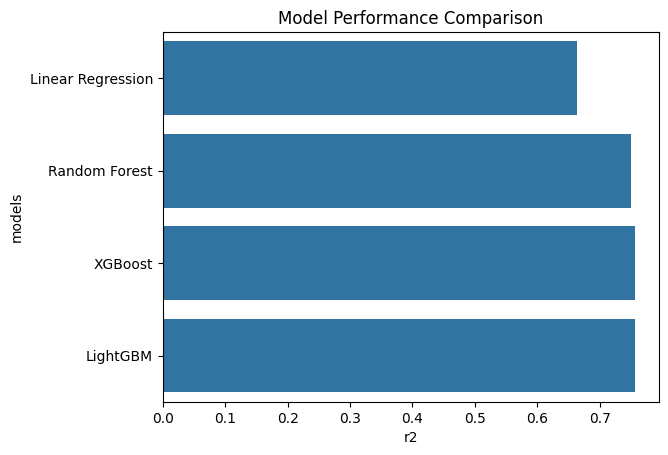

In [38]:
sns.barplot(results_df2, y = 'models', x = 'r2')
plt.title('Model Performance Comparison')
plt.show()

simillar to the previous modeling, which was done only using the original features,

Linear Regression has the lowest performance, which indicates its inability to  capture non-linear relationships.
Random Forest improves performance significantly compared to the linear regression model
XGBoost model performs slightly better than Random Forest, showing marginal gains from gradient boosting.
LightGBM gives the best R², yet not much different from thr random forest and XGBoost models.